# Dopravní nehody v České republice za rok 2020

Z důvodu dopravních nehod zemře ročně v České republice velký počet lidí. Mnohonásobně vyšší počet osob je pak zraněn a finanční ztráty jsou taktéž enormní. V této krátké statistické studii budeme tato čísla vyhodnocovat. Hlavním cílem bude zjistit, co bylo příčinou nehod a zda není možné nehodám předejít. Zajímá nás, jak velkou roli sehrál lidský faktor a zda by řidiče nebylo možné nahradit počítačem, který by mohl chybovost snížit. Může snaha automobilového průmyslu o vyrobení samoříditelných aut zachránit lidské životy? Pojďme se podívat.

Data pocházejí z [webu Policie ČR](https://www.policie.cz/clanek/statistika-nehodovosti-900835.aspx?q=Y2hudW09Mg%3d%3d).

Popis dat je [zde](https://www.policie.cz/soubor/polozky-formulare-hlavicky-souboru-xlsx.aspx).

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import chi2

from os import listdir
from os.path import isfile, join

In [2]:
year = 2020 # lze zmenit na jiny rok, pokud vyrobime slozku s danym rokem a daty z toho roku

## Příprava dat

Zde si připravíme data. Musíme spojit soubory ze všech složek (reprezentující měsíce) a ze všech souborů v těchto složkách (reprezentující kraje).

In [3]:
data_folder = './data/' + str(year)
months_folders = [join(data_folder, month_folder) for month_folder in sorted(listdir(data_folder))]

In [4]:
files_desc = [
    "praha",
    "stredocesky",
    "jihocesky",
    "plzensky",
    "ustecky",
    "kralovehradecky",
    "jihomoravsky",
    "moravskoslezsky",
    "none",
    "none",
    "none",
    "none",
    "none",
    "none",
    "olomoucky",
    "zlinsky",
    "vysocina",
    "pradubicky",
    "liberecky",
    "karlovarsky",
    "chodci"
]

In [5]:
data = [] # pole mesicu (indexovano od nuly)
# data = [data_leden, data_unor, ...]
# data_leden = {"prazsky" = pdObject, "stredocesky" = pdObject, ...}

for m in months_folders:
    month_data = {} # data from each district
    for i, f in enumerate(sorted(listdir(m))):
        if files_desc[i] != "none" and files_desc[i] != "chodci":
            month_data[files_desc[i]] = pd.read_csv(join(m, f), sep=';', header=None, low_memory=False)
            month_data[files_desc[i]] = month_data[files_desc[i]].drop_duplicates(subset=[0])
    data.append(month_data)

all_data_pds = [m[kraj] for m in data for kraj in m]
all_data_with_duplicates = pd.concat(all_data_pds) # cely rok a vsechny kraje
all_data = all_data_with_duplicates.drop_duplicates(subset=[0]) # vyhodime duplikaty (podle ID nehody)

# Souhrnné statistiky

Pojďme se podívat na základní údaje o nehodách.

In [6]:
print(f"Za rok {year} \n - zemřelo {all_data[13].sum()} lidí, výběrový průměr na jeden den = {round(all_data[13].sum()/366, 2)} lidí\n\
 - bylo těžce zraněno {all_data[14].sum()} lidí, výběrový průměr na jeden den = {round(all_data[14].sum()/366, 2)} lidí\n\
 - bylo lehce zraněno {all_data[15].sum()} lidí, výběrový průměr na jeden den = {round(all_data[15].sum()/366, 2)} lidí\n\
 - újma na majetku činila {all_data[16].sum() // 1000} milionů Kč, výběrový průměr na jeden den = {round(all_data[16].sum()/(1000*366), 2)} milionů Kč\n\
 - celkem nehod bylo {all_data.shape[0]}, výběrový průměr na jeden den = {round(all_data[14].sum()/366, 2)} nehod")

Za rok 2020 
 - zemřelo 472 lidí, výběrový průměr na jeden den = 1.29 lidí
 - bylo těžce zraněno 1557 lidí, výběrový průměr na jeden den = 4.25 lidí
 - bylo lehce zraněno 21040 lidí, výběrový průměr na jeden den = 57.49 lidí
 - újma na majetku činila 60143 milionů Kč, výběrový průměr na jeden den = 164.33 milionů Kč
 - celkem nehod bylo 94804, výběrový průměr na jeden den = 4.25 nehod


Údaje jsou dány do 24h po nehodě. Dále se počty mohly změnit. Na těžké zranení mohly oběti nehod podlehnout i několik dní po incidentu,
to zde ale už započítáno není. Data je tedy v tomto směru potřeba brát s rezervou.

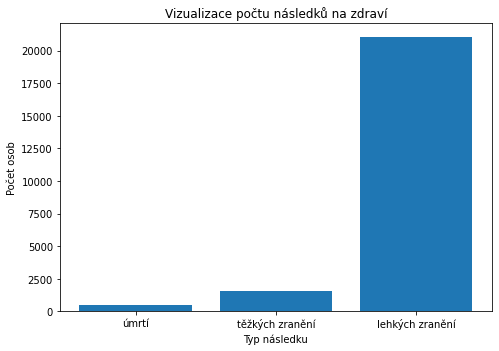

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
category = ['úmrtí', 'těžkých zranění', 'lehkých zranění']
numbers = [all_data[13].sum(), all_data[14].sum(), all_data[15].sum()]
ax.set_title('Vizualizace počtu následků na zdraví')
ax.set_xlabel('Typ následku')
ax.set_ylabel('Počet osob')
ax.bar(category,numbers)
plt.show()

Podívejme se, kolik lidí při nehodě zemře, pokud se nehoda stane tragickou. V naprosté většině zemře jeden člověk.

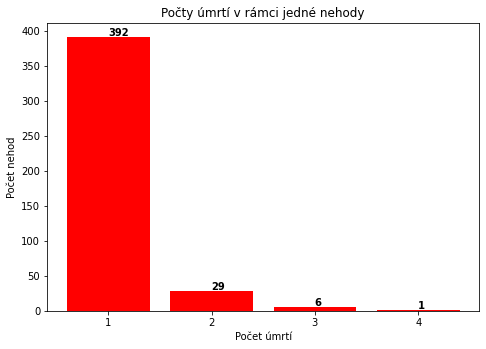

In [30]:
numbers = []
for num in range(1, all_data[13].max()+1):
    numbers.append(all_data[all_data[13] == num][13].count())

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
category = [str(i) for i in range(1, len(numbers)+1)]
ax.bar(category, numbers,color="r") #

ax.set_title('Počty úmrtí v rámci jedné nehody')
ax.set_xlabel('Počet úmrtí')
ax.set_ylabel('Počet nehod')

for i in range(len(category)):
    ax.text(category[i], numbers[i] + 2, numbers[i], weight='bold')
plt.show()

# Zajímavé statistiky

Naše hypotéza je, že když mimo obec nehoda nastane, je většinou smrtelná. Tato domněnka vychází z faktu,
že mimo obec se smí jezdit až 90 km/h, zatímco v obci je rychlost omezena na 50 km/h. 

In [9]:
mimo_obec = all_data[all_data[63] == 1]
v_obci = all_data[all_data[63] == 2]

print(f"Nehod mimo obec: {mimo_obec.shape[0]}, pravděpodobnost úmrtí při srážce mimo obec {round(100*mimo_obec[mimo_obec[13] > 0].shape[0]/mimo_obec.shape[0], 2)} %\n\
Nehod v obci: {v_obci.shape[0]}, pravděpodobnost úmrtí při srážce v obci {round(100*v_obci[v_obci[13] > 0].shape[0]/v_obci.shape[0], 2)} %")

Nehod mimo obec: 62280, pravděpodobnost úmrtí při srážce mimo obec 0.21 %
Nehod v obci: 32524, pravděpodobnost úmrtí při srážce v obci 0.92 %


Tuto hypotézu nijak hlouběji ověřovat nebudeme. Vyšlo nám totiž naopak to, že k úmrtí dojde spíše v obci než mimo obec.
Pravděpodobně při těchto nehodách je sražen chodec a z toho důvodu nehoda často končí tragicky.

## Nepřiměřená rychlost v obci končí z téměř 50ti procent zraněním nebo úmrtím osoby

Podívejme se na vskutku šokující fakt. Při téměř každé druhé nehodě, jejíž příčinou byla nepřiměřená rychlost
v obci, se někdo (minimálně) zraní. Opět jde nejspíš o chodce, kteří vejdou na vozovku a řidič již nestihne reagovat.

[Zdroje uvádějí](https://en.wikipedia.org/wiki/Mental_chronometry), že reakční doba člověka je zhruba 250ms. Pokud se plně nesoustředíme, bude to i mnohem více. Ačkoliv v tomto případě byla na vině nepřiměřená rychlost, můžeme se i přesto domnívat, že tento lidský faktor hraje velkou roli. Kdyby byl ve vozidle instalován [automatický brzdný systém](https://cars.usnews.com/cars-trucks/best-cars-blog/2016/10/what-is-an-automatic-braking-system), mohlo se nejspíš většině těchto následků předejít.


Mějme ale stále na mysli, že s opravdu vysokou rychlostí ani počítač nic nenadělá. Buďme tedy ve městech
opatrní a zkusme se těmito daty řídit.

In [10]:
vysoka_rychlost = v_obci[v_obci[12] > 200]
pocet_nehod_kvuli_rychlosti = vysoka_rychlost[vysoka_rychlost[12] < 250]
print(f"Pravděpodobnost újmy na zdraví při nehodě ve vysoké rychlosti v obci je \
{100*round(pocet_nehod_kvuli_rychlosti[pocet_nehod_kvuli_rychlosti[9] == 1].shape[0]/pocet_nehod_kvuli_rychlosti.shape[0], 4)} %.")

Pravděpodobnost újmy na zdraví při nehodě ve vysoké rychlosti v obci je 46.14 %.


## Prostor pro technická bezpečnostní zlepšení

Když člověku dáme do ruky několikatunový stroj s možností pohybovat se vysokou rychlostí, často lidské schopnosti nestačí k tomu,
aby stroj uřídily. Vzhledem k tomu, že v datech je uvedeno, jaká byla příčina nehody,
můžeme lehce zjistit, kolik jich bylo zaviněno řidičem.

In [11]:
zavineno_ridicem = all_data[all_data[12] > 200]
moznost_pro_autonomii = zavineno_ridicem[zavineno_ridicem[12] < 550]

print(f"Celkem {round(100*moznost_pro_autonomii.shape[0]/all_data.shape[0], 2)} % nehod je zaviněno řidičem (ne poruchou nebo jakýmkoliv vnějším vlivem).")

Celkem 82.68 % nehod je zaviněno řidičem (ne poruchou nebo jakýmkoliv vnějším vlivem).


## Za více jak 96 % úmrtí na silnicích může lidské zavinění

Pojďme se ale podívat na ty opravdu vážné nehody, při kterých někdo zemřel.

Kdo nehodu zavinil? Více jak 96 procent nehod zavinil člověk.

In [31]:
umrti = all_data[all_data[13] > 0]
zavineno_ridicem = umrti[umrti[12] > 200]
moznost_pro_autonomii = zavineno_ridicem[zavineno_ridicem[12] < 550]
print(f"Za celkem {round(100*moznost_pro_autonomii[13].sum()/umrti[13].sum(), 2)} % úmrtí může lidský faktor.")

Za celkem 96.61 % úmrtí může lidský faktor.


# Hypotéza

Mějme hypotézu, že počet nehod za den má normální rozdělení. Pojďme tuto hypotézu ověřit.

Nejdříve si musíme připravit data.


In [13]:
# pocty dnu v mesici napocitano na mych prstech (2020 byl prestupny rok)
max_days_in_month = [31,29,31,30,31,30,31,31,30,31,30,31]

In [14]:
nehody = [] # jednotlive nehody za kazdy den v roce
for m in range(1, 13):
    for day in range(1, max_days_in_month[m-1] + 1):
        denni_nehody = all_data[all_data[3].str.contains(str(year) + "-" + str(m).zfill(2) + "-" + str(day).zfill(2))]
        nehody.append(denni_nehody.shape[0])

In [15]:
nehody = np.array(nehody)

Data rozdělíme do sedmi binů vždy po stovce nehod za daný den.

In [16]:
num_of_bins = 7
a = np.digitize(nehody, [100, 200, 300, 400, 500, 600, 700]) # rozdelime nehody do binu

unique, counts = np.unique(a, return_counts=True)
hist = dict(zip(unique, counts))

# je mozne, ze nejaky bin nema zadny prvek, v tom pripade musime do dict pridat bin s 0 prvky
for i in range(0,num_of_bins):
    if i not in hist:
        hist[i] = 0

hodnoty = []
keys_sorted = sorted(hist.keys()) # seradime keys (tzn. biny tak, aby davaly smysl)

# a precteme postupne hodnoty z binu (takze jsou serazene stejne jako biny)
for k in keys_sorted:
    hodnoty.append(hist[k])

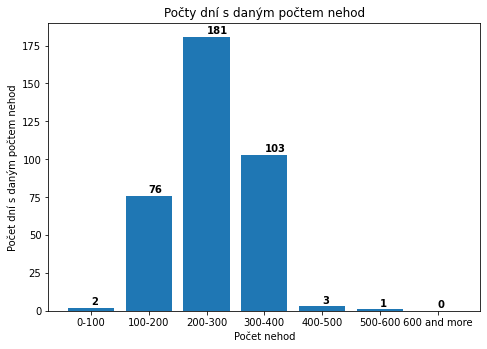

In [32]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
category = ["0-100", "100-200","200-300","300-400","400-500","500-600", "600 and more"]
numbers = list(dict(zip(keys_sorted, hodnoty)).values())

ax.set_title('Počty dní s daným počtem nehod - naměřeno z dat')
ax.set_xlabel('Počet nehod')
ax.set_ylabel('Počet dní s daným počtem nehod')

ax.bar(category,numbers)
for i in range(len(category)):
    ax.text(category[i], numbers[i] + 2, numbers[i], weight='bold')
plt.show()

Histogram podle oka opravdu připomíná normální rozdělení.
Spočtěme nejdříve střední hodnotu (pomocí výběrového průměru) a rozptyl (pomocí výběrového rozptylu).

In [18]:
E = (1/nehody.shape[0]) * np.sum(nehody)
o2 = (1/(nehody.shape[0]-1)) * np.sum((nehody - E)**2)
print(f"Výběrový průměr počtu nehod za den je {E}.")
print(f"Výběrový rozptyl počtu nehod za den je {o2}.")

Výběrový průměr počtu nehod za den je 259.0273224043716.
Výběrový rozptyl počtu nehod za den je 3982.7225391122092.


Nyní použijeme test dobré shody. Spočteme statistiku T, k tomu je třeba spočítat hodnoty $E_i$, kde $i$ je jednotlivý bin. Tyto hodnoty značíme v kódu jako `Ecka`. $\alpha$ zvolme jako 0.05.

In [19]:
# zjistime pravdepodobnosti, pokud se proces opravdu ridi nahodnym rozdelenim
cdf = [0]
right_probs = []
for i in range(num_of_bins):
    cdf.append(norm.cdf((i+1)*100, E, np.sqrt(o2)))
    right_probs.append(cdf[-1] - cdf[-2])

right_probs = np.array(right_probs)

In [20]:
Ecka = right_probs * nehody.shape[0] # kolik by melo uplne dokonale byt v binech
T = np.sum(((numbers - Ecka)**2)/ Ecka)

Když vyobrazíme počty na grafu, vypadají skoro totožně s grafem, který jsme získali z oficiálních dat.

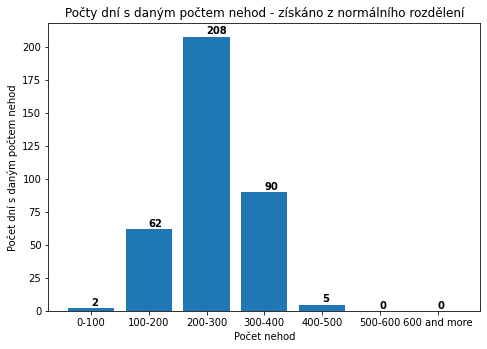

In [33]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
category = ["0-100", "100-200","200-300","300-400","400-500","500-600", "600 and more"]
numbers = list(dict(zip(keys_sorted, hodnoty)).values())

ax.set_title('Počty dní s daným počtem nehod - získáno z normálního rozdělení')
ax.set_xlabel('Počet nehod')
ax.set_ylabel('Počet dní s daným počtem nehod')

ax.bar(category,Ecka)
for i in range(len(category)):
    ax.text(category[i], Ecka[i] + 2, round(Ecka[i]), weight='bold')
plt.show()

In [22]:
gamma = chi2.ppf(0.95, num_of_bins-1)
print("T =", str(T))
print("Gamma =", str(gamma))

T = 47.89834310501037
Gamma = 12.591587243743977


Jak je vidět, T > Gamma a proto můžeme hypotézu zamítnout. Což je ale zarážející, protože grafy vypadají opravdu stejně. Pohrál jsem si tedy s daty a zjistil jsem, že v předposledním binu je v našich datech právě jedno dato, ale ideálně by tam být nemělo. Co to je za dato? Z jakého dne toto dato je? Ukáže se, že je to úplně z prvního dne, tedy z 1. ledna 2020. To mi přijde trošku podezřelé. Je to možná nějaká malá chyba v datech, např. některé nehody z posledního dne roku 2019 se započítaly až do nového roku.

Zkusme tento den tedy z našich dat odstranit a spočítat hodnotu T znovu. 

In [23]:
print(f"Nejvíce nehod je ze dne číslo {np.argmax(nehody)}, tzn. z 1. ledna 2020.")

Nejvíce nehod je ze dne číslo 0, tzn. z 1. ledna 2020.


In [24]:
bez_outliera = numbers
bez_outliera[5] = 0

In [25]:
T = np.sum(((bez_outliera - Ecka)**2)/Ecka)

In [26]:
gamma_bez_outliera = chi2.ppf(0.95, num_of_bins-1)
print("T bez jednoho data =", str(T))
print("Gamma bez jednoho data =", str(gamma_bez_outliera))

T bez jednoho data = 9.201211521025279
Gamma bez jednoho data = 12.591587243743977


V tomto případě je už opravdu T < Gamma a hypotézu už zamítnout nemůžeme. Je vidět, že test je velice citlivý a otázkou je, jestli je správné, že jsme dato odstranili.

# Závěr

V tomto malém průzkumu jsme si ověřili, že lidský faktor hraje při řízení vozidel opravdu velkou roli. Naprostá většina úmrtí je totiž zaviněna člověkem. Snaha automobilek vyrobit autonomní řídící systémy pro automobily je tedy výbornou snahou, která může potenciálně záchránit v České republice stovky lidí, tisíce až desetitisíce osob by nemuselo přijít k vážnému úrazu a ušetřily by se desítky miliard Kč.

Maximální rychlost v obci je často brána na lehkou váhu, ukázali jsme ale, že pokud už dojde k nehodě z důvodu vysoké rychlosti, ze 46ti procent přijde někdo ke zdravotní újmě. Buďme tedy trpěliví a zkusme se těmto nehodám vyhnout. Je lepší si v práci vymyslet hloupou výmluvu a dostat trochu vynadáno než zranit nebo dokonce zabít sebe nebo druhou někoho jiného. Úplně nejlepší je ale možná vyrazit na schůzku včas, ale to by svět musel být ideální, aby se nám to vždy dařilo.

Úplně nakonec jsme ukázali, že počet nehod za jeden den se řídí normální distribucí. Tento fakt je možné použít k tomu, aby záchranné složky věděly, jak mají být připravené. V průběhu výpočtu jsme 